In [1]:
# consider dealing with outliers
# analyze sentiment and word count on both
# most frequent words in (1,2)

# things to clean
# appostrophes? quotes?
# Streets? NW E | st, ave, lane, ...
# lower?

# helpful for seeing if text cleaning was successful
# print(sea.loc[sea['text'].str.contains('City Council Newsletters'), 'text'].iloc[0])
# print()

# look at results of drop stop stem text
#

# Comparing r/seattle and r/seattlewa

---

# Problem Statement

---

Describe Reddit

Interestingly, there are at least two subreddits for the city of Seattle: r/Seattle and r/SeattleWA. Our goal is to create an NLP model that will attempt to distinguish posts between these two subreddits. In the process, we hope to gain insight about why these two separate subreddits exist for the same city.

Classification model. This is a challenging problem, and there are certainly people who post in either subreddit without a considering why they are choosing one over the other. This is a level of randomness we do not know the size of and cannot eliminate in our examination. Since we should expect an accuracy of 50% without any help of a model, let us call success an accuracy above 70%.

---

## Imports and Functions

In [1]:
import requests
import time
from ratelimit import limits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [56]:
def scrape_subreddit(subreddit):
    '''
    Given subreddit's name, request the most recent 2,250
    posts from the given subreddit.
    
    Combines the data into a csv file.
    '''
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': subreddit,
              'size': 250,
              'is_self': True,
              'selftext:not': '[removed]'}
    
    # assigns post data to variable 'posts'
    data = requests.get(url, params).json()
    posts = data['data']
    
    # adds the earliest post time to the 'before' API parameter
    # next request will collect posts before this time
    params['before'] = posts[-1]['created_utc']
    
    time.sleep(30)
    
    while len(posts) < 2_250:
        # collects next batch of posts data as 'next_posts'
        next_data = requests.get(url, params).json()
        next_posts = next_data['data']
        
        # concatenate posts data to 'posts'
        posts += next_posts
        
        # update API parameters to so the following 250 posts
        # will be requested in the next iteration of the loop
        earliest_post_time = next_posts[-1]['created_utc']
        params['before'] = earliest_post_time
        
        # delay next request and not spam the API
        time.sleep(30)
        
    posts_df = pd.DataFrame(posts)
    posts_df.to_csv(f'datasets/{subreddit}.csv', index = False)
    

def text_cleaning(text):
    '''
    Cleans text by removing [bracketed statements], urls, emails,
    some special characters (parentheses and stars), and some common html phrases.
    
    Returns the cleaned text
    '''
    
    # remove new lines
    text = re.sub('\n', ' ', text)
    
    # remove parentheses and asterisks
    text = re.sub("[\(\)\*]", '', text)
    
    # remove urls and do not include closing bracket ]
    text = re.sub('http\S+|www\.\S+', '', text)
    
    # remove bracketed strings
    text = re.sub('\[(\w|\s)*\]', '', text)
    
    # remove any leftover brackets
    text = re.sub('[\[\]]', '', text)
    
    # replace parentheses with spaces
    text = re.sub("/", ' ', text)
    
    # remove some common html phrases
    text = re.sub('&(gt|lt);', '', text)
    text = re.sub('&amp;', '', text)
    text = re.sub('&?#x200b;?', '', text)
    text = re.sub('&?#x200B;?', '', text)
    
    # remove email accounts
    text = re.sub('\S+@\S+', '', text)
    
    # replace whitespace with single space
    text = re.sub('\s+', ' ', text)
    
    # drop stopwords and stem
    #pstem = PorterStemmer()
    #text = ' '.join([pstem.stem(word) for word in text.split() if word not in stopwords.words('english')])
    
    return text


# although stop_drop_and_stem is a cooler name
# it would be slightly less clear :(
def drop_stop_and_stem(text):
    '''
    Takes a string, drops the stop words,
    and stems the remaining words with PorterStemmer.
    
    Returns the stemmed, non-stopwords
    '''
    
    pstem = PorterStemmer()
    
    #stem non-stopwords and put into a list
    stemmed_list = [pstem.stem(word) for word in text.split()
                    if word not in stopwords.words('english')]
    
    # return words separated by a space
    return ' '.join(stemmed_list)


def create_sentiment(df):
    '''
    Using Vader, collects sentiment from a DataFrame's "text" column.
    Creates three new columns titled "sent_pos", "sent_neg", and "sent_comp" from the 
    positive, negative, and compound sentiment scores.
    
    Returns the DataFrame with additional columns "sent_pos", "sent_neg", and "sent_comp".
    '''
    
    sent = SentimentIntensityAnalyzer()
    
    df['sent_pos'] = df['text'].apply(lambda x: sent.polarity_scores(x)['pos'])
    df['sent_neg'] = df['text'].apply(lambda x: sent.polarity_scores(x)['neg'])
    df['sent_compound'] = df['text'].apply(lambda x: sent.polarity_scores(x)['compound'])
    

def sample_three(series):
    '''
    Prints three random entries from a given series.
    '''
    for entry in series.sample(3):
        print(entry)
        print('----------\n')

In [3]:
# collect more than 2,250 posts from /r/Seattle and /r/SeattleWA subreddits
# commented out because the data has already been collected

#scrape_subreddit('Seattle')
#scrape_subreddit('SeattleWA')

---

## Basic Cleaning

In [36]:
sea = pd.read_csv('datasets/Seattle.csv')
sea_wa = pd.read_csv('datasets/SeattleWA.csv')

Through reading the two csv files I identified the columns below would be most relevant in search.

In [37]:
# columns of interest
init_cols = ['subreddit', 'author', 'created_utc', 'title', 'selftext']

sea = sea[init_cols].copy()
sea_wa = sea_wa[init_cols].copy()

Let us see if there are any blatant things to clean in the data.

In [38]:
sea.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       0
dtype: int64

In [39]:
sea_wa.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       3
dtype: int64

In [40]:
print(sea.shape)
print(sea_wa.shape)

(2499, 5)
(2499, 5)


In [41]:
sea_wa.dropna(inplace = True)

There should not be any harm in removing three entries with missing selftext data out of nearly 2,500 posts.

Since we will eventually want to look over text from both title and selftext, let us concatenate these columns.

In [42]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

Next we clean need to clean the data. Below we our `text_cleaning` function to do basic cleaning like remove urls, select special characters, and bracketed text.

After cleaning we will collect sentiment from our text through `vader`, then drop stopwords, and finally stem. We collect sentiment first because `vader` may have trouble performing sentiment analysis on stemmed text.

In [43]:
# remove urls and emails, special characters ()/*, and [bracketed strings]
sea['text'] = sea['text'].apply(text_cleaning)
sea_wa['text'] = sea_wa['text'].apply(text_cleaning)

In [44]:
# in place methods that generate positive and negative sentiment scores
# for the given dataframes
create_sentiment(sea)
create_sentiment(sea_wa)

In [46]:
# count number of words by splitting text across white space and recording list length
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

In [57]:
sea_wa.head()

,subreddit,author,created_utc,title,selftext,text,sent_pos,sent_neg,sent_compound,word_count
0,SeattleWA,Sinkholediaries,1664416603,Archspire fans?,I'm a lady who is obsessed. I need other frien...,Archspire fans? I'm a lady who is obsessed. I ...,0.206,0.284,-0.4939,31
1,SeattleWA,prf_q,1664406559,Is it the overseeding season yet?,Those who are maintaining a lawn: Are you over...,Is it the overseeding season yet? Those who ar...,0.069,0.000,0.3485,35
2,SeattleWA,eatmoremeatnow,1664404071,Showbox Box Office?,Has anybody recently bought a ticket from the ...,Showbox Box Office? Has anybody recently bough...,0.034,0.058,-0.3270,55
3,SeattleWA,xixi90,1664398109,[Public Policy Poll] Patty Murray (D) leads Ti...,https://www.publicpolicypolling.com/wp-content...,Patty Murray D leads Tiffany Smiley R 52.0 - ...,0.114,0.000,0.4019,25
4,SeattleWA,irish_gnome,1664320032,Gas prices going back up?,Just watched the local gas station raise their...,Gas prices going back up? Just watched the loc...,0.000,0.084,-0.3736,29


In [65]:
# clean up print statements and rerun fresh
print(sea[sea['text'].duplicated()].sort_values(by = 'author').shape)
print(sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').shape)
sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').head(10)

(0, 10)
(0, 10)


,subreddit,author,created_utc,title,selftext,text,sent_pos,sent_neg,sent_compound,word_count


In [64]:
sea.drop_duplicates('text', inplace = True)
sea_wa.drop_duplicates('text', inplace = True)

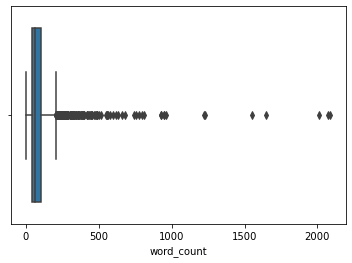

In [47]:
sns.boxplot(x = sea['word_count']);

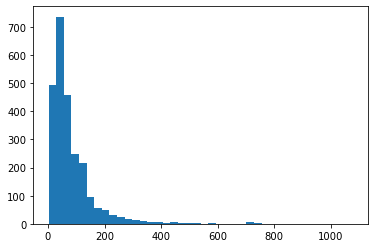

In [48]:
plt.hist(sea_wa['word_count'], bins = 40);

In [49]:
# before dropping, analyze length (build word count column)
# drop outliers (look at distribution of word counts)
# concatenate

<AxesSubplot:ylabel='Frequency'>

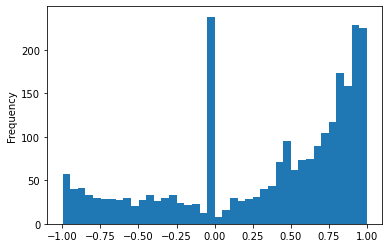

In [52]:
sea_wa['sent_compound'].plot.hist(bins = 40)

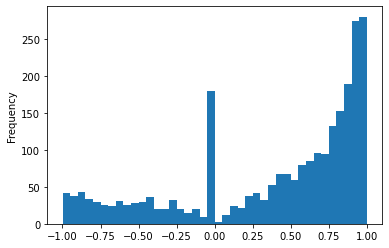

In [53]:
sea['sent_compound'].plot.hist(bins = 40);

<AxesSubplot:ylabel='Frequency'>

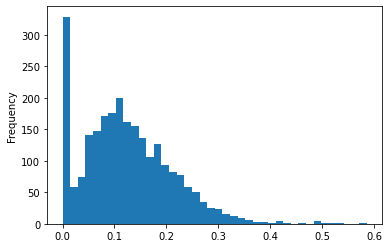

In [54]:
sea['sent_pos'].plot.hist(bins = 40)

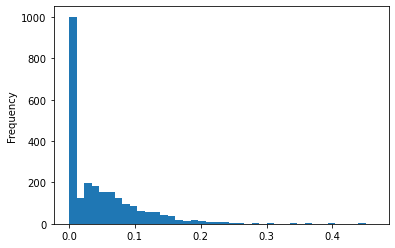

In [33]:
sea['sent_neg'].plot.hist(bins = 40);

In [65]:
# drop stopwords and then stem the text data
sea['text'] = sea['text'].apply(drop_stop_and_stem)
sea_wa['text'] = sea_wa['text'].apply(drop_stop_and_stem)

In [67]:
sea.drop(columns = ['title', 'selftext'], inplace = True)
sea_wa.drop(columns = ['title', 'selftext'], inplace = True)

In [ ]:
pd.concat([sea, sea_wa])

In [31]:
sea['text'].iloc[0]

'special educ seattl surround areas? i’ll reloc seattl come month daughter down syndrom join special educ class somewher still look henc post ani recommend privat school specif school district better equip provid need has? i’d like time learn aid life skill build home, also inclus time children art, pe, danc classes. thank you.'

In [15]:
sea_wa['text'].apply(lambda text: ' '.join(pstem.stem(word) for word in text.split() if word not in stopwords.words('english')))

0       archspir fans? i'm ladi obsessed. i need frien...
1       is overseed season yet? those maintain lawn: a...
2       showbox box office? ha anybodi recent bought t...
3       patti murray d lead tiffani smiley r 52.0 - 40...
4       ga price go back up? just watch local ga stati...
                              ...                        
2494    place similar the ave udistrict? i move downto...
2495    stolen bag seatac i carri bag stolen airport s...
2496    bad bunni ticket hello all, my friend i tri se...
2497    plan vacation! what reddit recommend? just tit...
2498    day-hik suggest end march? hello, i'm visit se...
Name: text, Length: 2496, dtype: object

In [ ]:
CountVectorizer()

In [111]:
for i in range(5):
    print(sea['text'].iloc[i])

special educ in seattl or surround areas? i’ll be reloc to seattl in the come month and my daughter ha down syndrom and will be join a special educ class somewher still look and henc thi post ani recommend on privat school or ani specif school district better equip to provid the need she has? i’d like for her to have time to learn with an aid the life skill we build on at home, but to also have some inclus time with the other children dure art, pe, or danc classes. thank you.
best lyche martini in seattle? i’m on the hunt for the best lyche martini in seattle. ani recommend for where to go? thanks!
save a life! hi! i just learn in a cpr first aid class that there' a program for washington residents, where you can have free nalaxon mail to you. it easi to use if you think someon is have an overdose. and two import things: it will not hurt someon who is not have an overdose, becaus it onli bind to opioid receptors. so if the person is on someth else, or not in full overdose, they’ll be a

In [84]:
sea_wa.loc[sea_wa['text'].str.contains('manager was peeing in milkshake mix'), 'text'].iloc[0]

"Vancouver Arby's manager was peeing in milkshake mix "

In [64]:
for entry in sea_wa['text'].sample(3):
    print(entry)
    print('----------\n')

Anyone want a new $250K year job? It actually sounds like an awesome gig for the right person. I worry the environment would be awfully woke I'd have to really count to 10 everytime I had to meet with Kevin but overall it seems like sort of a dream job.
----------

Softball Leagues Hi all! Just moved to Seattle and I love to play softball and looking for a little a bit of help finding a team league. Seeking a Friday night or Saturday morning league for the fall. Open to men’s, co-ed, slow pitch or fast pitch that is more competitive than not. Ideally double headers, but ok if not. Willing to drive up to 45 mins in any direction from south Seattle. I was able to find Underdog on Google, but didn’t look like there was any Friday or Saturday options, and no double headers. Was thinking there may be better options slightly outside the city. Also would love to know of any pickup games going on during the week. Please comment or shoot me a DM if you know of anything. Thanks in advance!
-----

---

As alluded to above, there are several rows with repeated title and selftext. We print out the repetitions below. Whether these posts are repeated intentionally (maybe as advertisement) or not, it is probably fair to remove these posts.

We should also be weary of posts containing minimal title text **and** minimal selftext. For example, posts with links and no substance will likely not be helpful in creating a strong performing model. **Let us remove posts with a `selftext` and `title` word counts are both less than or equal to five.**

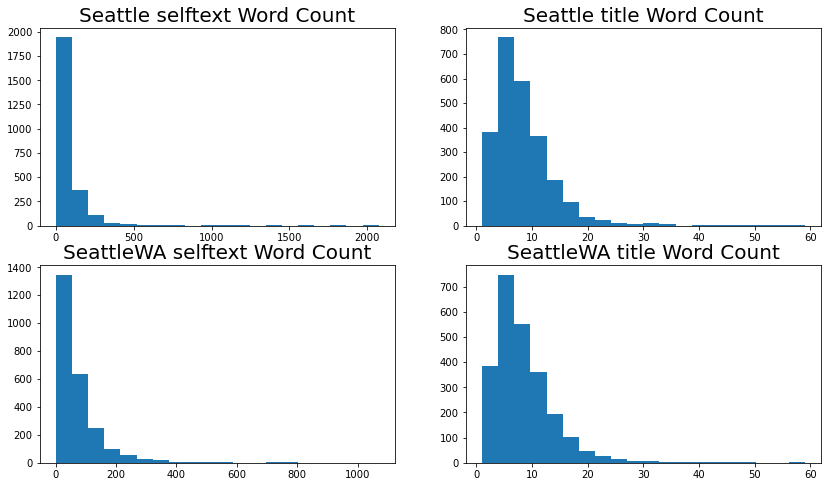

In [146]:
plt.figure(figsize = (14,8))

# iterator for subp
i = 1
for subreddit in [sea, sea_wa]:
    for col in ['selftext', 'title']:
        plt.subplot(2,2,i)
        plt.title(f"{subreddit['subreddit'].iloc[0]} {col} Word Count", size = 20)
        plt.hist(subreddit[col].str.split().str.len(), bins = 20);
        
        i += 1

In [93]:
# boolean list of entries with fewer than 5 'words' in Seattle
sea_selftext_lt5 = (sea['selftext'].str.split().str.len() <= 5)
sea_title_lt5 = (sea['title'].str.split().str.len() <= 5)

# boolean list of entries with fewer than 5 'words' in SeattleWA
sea_wa_selftext_lt5 = (sea_wa['selftext'].str.split().str.len() <= 5)
sea_wa_title_lt5 = (sea_wa['title'].str.split().str.len() <= 5)

# print number of posts removed from filtering
print(f'{len(sea[sea_selftext_lt5 & sea_title_lt5])} posts removed from r/Seattle')
print(f'{len(sea_wa[sea_wa_selftext_lt5 & sea_wa_title_lt5])} posts removed from r/SeattleWA')

#filter out posts with fewer than 5 words in selftext and title
sea = sea[(~sea_selftext_lt5) & (~sea_title_lt5)].copy()
sea_wa = sea_wa[(~sea_wa_selftext_lt5) & (~sea_wa_title_lt5)].copy()

11 posts removed from r/Seattle
29 posts removed from r/SeattleWA


This did not remove many posts, but was performed out of an abundance of caution.

We could also explore posts with large word counts, but there is little reason to be suspicious of such posts. Although more rare, the occassional lengthy post is fairly expected.

In [168]:
sea.loc[sea['selftext'].str.split().str.len() > 1500, 'selftext'].shape

(5,)

In [169]:
i = 0
for entry in sea.loc[sea['selftext'].str.split().str.len() > 1500, 'selftext']:
    print(f'{i}: ---------\n-------------\n-------------\n')
    print(entry, '\n')
    i += 1

0: ---------
-------------
-------------

Reddit:

Hey everyone! I just wanted to introduce myself again. My name is George, and I am a rising junior at Stanford interested in civic engagement and politics. I started working on a project with other students that’s been totally awesome and cool. Basically, we’ve made a newsletter that summarizes the info from Seattle City Council meetings in an accessible and easy way. I have put an example from this week below, though the real thing has a bit more formatting that doesn't translate into Reddit. This project is very new, so we would really appreciate any feedback you may have! I would love to see comments and show me what I need to do to make this newsletter the best it can be. I totally recommend joining! Who doesn’t want to know what goes on behind the scenes of their own beautiful city? If you are interested in receiving these weekly in your email inbox, you can click this link: [https://forms.gle/Yxo5fevVhVWmwcB78](https://forms.gle/

---

## Feature Engineering

Before we perform any string vectorization, let us perform some basic feature engineering. Our plan is to:
- combine title and selftext columns for a single column to vectorize
- create a word count column
- create a sentiment column

#### Combine `title` and `selftext`

In [94]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

#### Create a `word_count` Column

In [95]:
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

#### Create Sentiment Columns

In [96]:
sent = SentimentIntensityAnalyzer()

In [97]:
sea['sent_pos'] = sea['text'].map(lambda x: sent.polarity_scores(x)['pos'])
sea['sent_neg'] = sea['text'].map(lambda x: sent.polarity_scores(x)['neg'])

sea_wa['sent_pos'] = sea_wa['text'].map(lambda x: sent.polarity_scores(x)['pos'])
sea_wa['sent_neg'] = sea_wa['text'].map(lambda x: sent.polarity_scores(x)['neg'])

---

## Predicting From Strictly Text Data

When we look at self text with fewer than three spaces they consist of:
- emojis,
- links,
- '\[deleted\]'
- some variations on 'title' or 'thank you' or '...'

It seems reasonable to assume that posts corresponding to the last bullet have a more thorough title. It is probably fine to keep these rows. The string vectorizers drop emojis unless we tell it not to, so we do not have to worry about them for now. The deleted entry should be removed.

It is harder to know what to do with links. Let us explore this a bit more thoroughly after performing some light cleaning.

Another thing to notice is that some links, 'deleted', and 'removed' are wrapped in square brackets. We explore this below to see if this unveils anything we should deal with.

In [255]:
sea.loc[(sea['selftext'].str.contains('\[')) & (sea['selftext'].str.len() < 300), 'selftext'].head(20)

269     It's Banned Books Week - [https://www.thenewst...
458     This guy just flew over me super low and accor...
660     [https://www.kuow.org/stories/making-good-prog...
750     As we enter the third missed day of school it'...
873                                               [Title]
926     [Desk in question](https://www.ikea.com/us/en/...
1190    Looking to park overnight a few nights while l...
1292    [https://youtu.be/DMNSvHswljM](https://youtu.b...
1498    Got about 20 paintings I made a while back tha...
1735    There is a ton of balanced and accurate info [...
1766    [https://www.kuow.org/stories/seattle-passes-p...
1810    [Festival Lineup](https://i.imgur.com/sSUkny1....
1903    What are some of your hacks and pro tips? Whet...
2137    [https://content.govdelivery.com/bulletins/gd/...
2303    [https://www.scribd.com/document/232200355/Upd...
2337                                            [deleted]
2381    [like this one for LA](https://www.lataco.com/...
Name: selftext

In [252]:
sea.loc[926, 'selftext']

"[Desk in question](https://www.ikea.com/us/en/p/trotten-desk-sit-stand-white-s79429602/)\n\nI bought it just 6 months ago but upgraded. It has a lever for the height adjustment. It's fully assembled."

In [254]:
sea.loc[1190, 'selftext']

'Looking to park overnight a few nights while lodging in Belltown. Where’s the closest neighborhoods to park for free? [cat tax ](https://imgur.com/a/TMVxjEQ)'

In [253]:
sea.loc[1292, 'selftext']

'[https://youtu.be/DMNSvHswljM](https://youtu.be/DMNSvHswljM)'